# GP Fitting of FRBs

In this, we want to fit a Gaussian Process to each integrated FRB light curve, and then subtract that template from the data in order to get a "difference" image that maps how different types of FRBs do different things. Let's try it!

### Loading FRB Data
Let's load in some FRB data and see what we can do with it:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")

import numpy as np
import glob

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from tinygp import GaussianProcess
from tinygp import kernels

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

import umap
datadir = "/Users/daniela/work/data/frbs/sims/"
outdir = "/Users/daniela/work/data/frbs/sims/"

file_basestring = "1000_Constant_SNR_"

cats = ["complex", "drifting", "simple_broad", "simple_narrow", "simulated_scattered"]

Function to plot dynamic spectra:

In [2]:
def plot_dynamic_spectra(dynamic_spectra, ax=None, title="Dynamic Spectra"):
    """
    Plot a dynamic spectrum with horizontal time axis and reversed frequency axis.

    Parameters:
        dynamic_spectra (numpy.ndarray): The dynamic spectrum to plot.
        title (str): The title for the plot (default is "Dynamic Spectra").

    Returns:
        None
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    # Calculate the time step based on the number of time samples
    num_time_samples = dynamic_spectra.shape[0]
    time_step = 0.0000256  # Default time step in seconds

    # Calculate the extent based on the number of frequency channels
    extent = [0, num_time_samples * time_step * 1000, 1208, 1700]

    ax.imshow(dynamic_spectra.T, aspect="auto", cmap="viridis", extent=extent)
    ax.set_xlabel("Time (ms)", size=14)
    ax.set_ylabel("Frequency (MHz)", size=14)
    ax.set_title(title, size=16)


Let's load in all bursts from a single category:

In [3]:
# empty dict for all burst data
bursts = {}

# start with first index
for i, c in enumerate(cats):
    # construct string for the correct directory
    cat_string = datadir + file_basestring + c + "/"
    
    # find all burst files
    burstfiles = glob.glob(cat_string  + "*.npy")
    
    # load all bursts from this type of bursts:
    bdata_all = []
    for bf in burstfiles:
        bdata = np.load(bf)
        bdata_all.append(bdata)
    bdata_all = np.array(bdata_all)

    bursts[c] = bdata_all

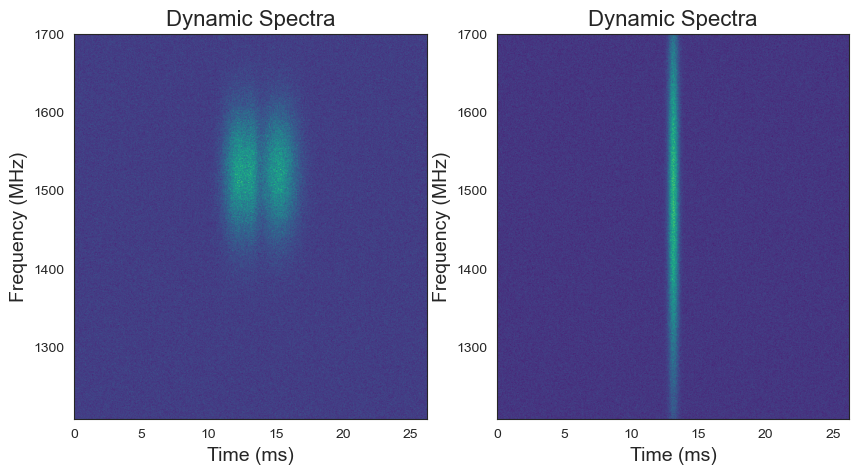

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

b1 = bursts["complex"][500]
plot_dynamic_spectra(b1, ax=ax1)

b2 = bursts["simple_broad"][0]
plot_dynamic_spectra(b2, ax=ax2)

Let's rebin the data:

In [5]:
def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

In [6]:
# empty dict for all burst data
bursts_rebin = {}

# start with first index
for i, c in enumerate(cats):

    brebin_all = []
    for b in bursts[c]:
        brebin = rebin(b, (int(1024/4), int(512/4)))
        brebin_all.append(brebin)
    brebin_all = np.array(brebin_all)

    bursts_rebin[c] = brebin_all

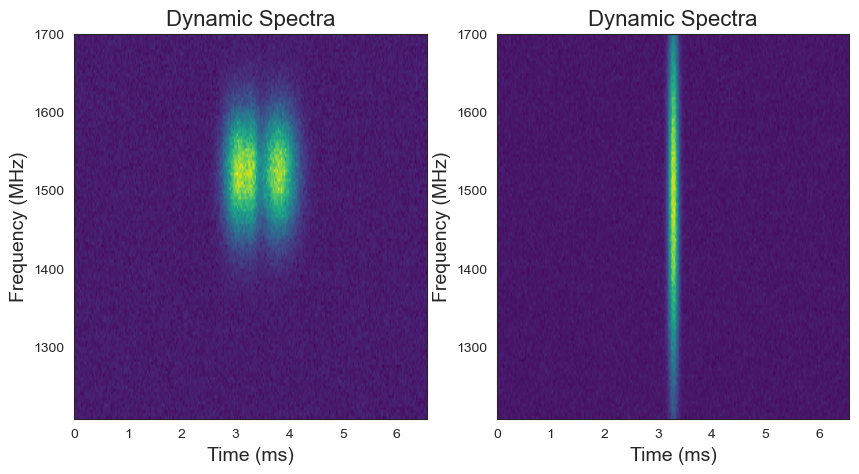

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


b1 = bursts_rebin["complex"][500]
plot_dynamic_spectra(b1, ax=ax1)

b2 = bursts_rebin["simple_broad"][0]
plot_dynamic_spectra(b2, ax=ax2)


## Gaussian Process Fit

Let's give it a try:

Text(0, 0.5, 'Integrated flux')

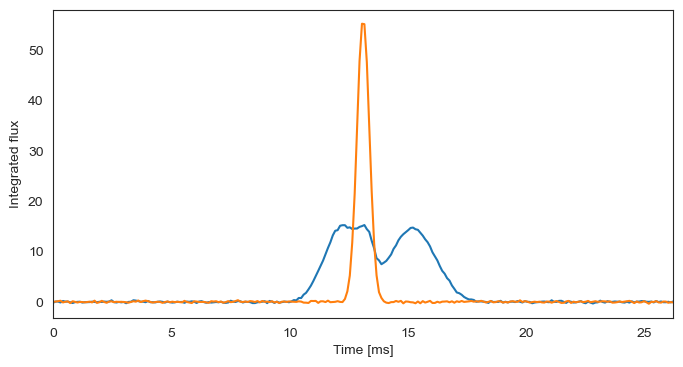

In [8]:
f1 = np.sum(b1, axis=1)
f2 = np.sum(b2, axis=1)

ntime = len(f1)

dt = 0.0256*4
time = np.linspace(0, dt*ntime, ntime)

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(time, f1)
ax.plot(time, f2)
ax.set_xlim(time[0], time[-1])
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Integrated flux")

In [9]:
def build_gp(params, x):
    kernel = jnp.exp(params["log_amp"]) * kernels.ExpSquared(
        jnp.exp(params["log_scale"])
    )
    return GaussianProcess(kernel, x, diag=jnp.exp(params["log_diag"]))

def neg_log_likelihood(theta, x, y):
    gp = build_gp(theta, x)
    return -gp.log_probability(y)

obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

In [10]:
f1_logstd = np.log(np.std(f1[:100]))
f1_amp = np.log(np.max(f1))
f1_logscale = np.log(0.1)

b1_param_init = {"log_scale":f1_logscale, 
              "log_amp": f1_amp,
              "log_diag": f1_logstd}

In [11]:
gp = build_gp(b1_param_init, time)
xtest = np.linspace(time[0], time[-1], 2000)
_, cond_gp = gp.condition(f1, xtest)


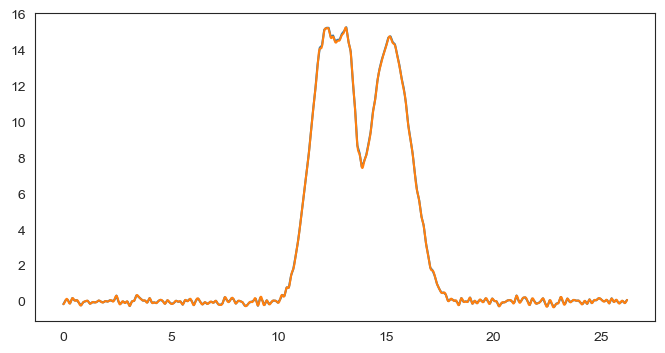

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(time, f1)
ax.plot(xtest, cond_gp.mean)

In [13]:
import jaxopt

solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
soln = solver.run(b1_param_init, x=time, y=f1)
print(f"Final negative log likelihood: {soln.state.fun_val}")

Final negative log likelihood: 42.628803665365666


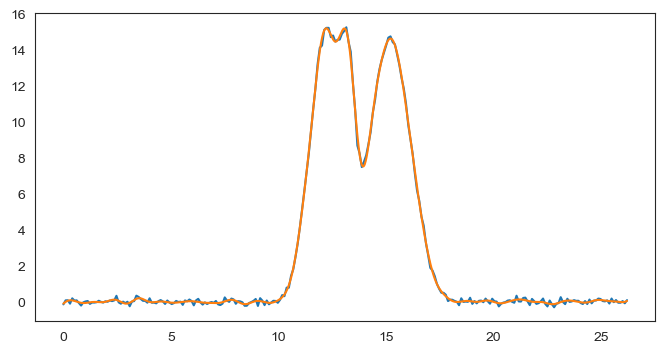

In [14]:
gp_fit = build_gp(soln.params, time)
_, cond_gp_fit = gp_fit.condition(f1, xtest)

fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(time, f1)
ax.plot(xtest, cond_gp_fit.mean)

In [15]:
def fit_gp(time, flux):
    """
    Function to fit a GP to an FRB light curve.

    Parameters
    ----------
    time : numpy.ndarray
        Array with time stamps

    flux : numpy.ndarray
        Array with fluxes

    Returns
    -------
    fitparams : numpy.ndarray
        An array with the best-fit parameters

    model_flux : numpy.ndarray
        An array of model fluxes
    """
    
    # set initial parameters
    flux_logstd = jnp.log(np.std(flux[:100]))
    flux_amp = jnp.log(np.max(flux))
    flux_logscale = jnp.float64(np.log(0.1))
    
    param_init = {"log_scale":flux_logscale, 
                  "log_amp": flux_amp,
                  "log_diag": flux_logstd}

    gp = build_gp(param_init, time)
    #xtest = np.linspace(time[0], time[-1], 5000)
    solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
    soln = solver.run(param_init, x=time, y=flux)
    #print(f"Final negative log likelihood: {soln.state.fun_val}")

    gp_fit = build_gp(soln.params, time)
    _, cond_gp_fit = gp_fit.condition(flux, time)

    return soln.params, cond_gp_fit.mean


In [16]:
f1_fit_params, f1_model = fit_gp(time, f1)

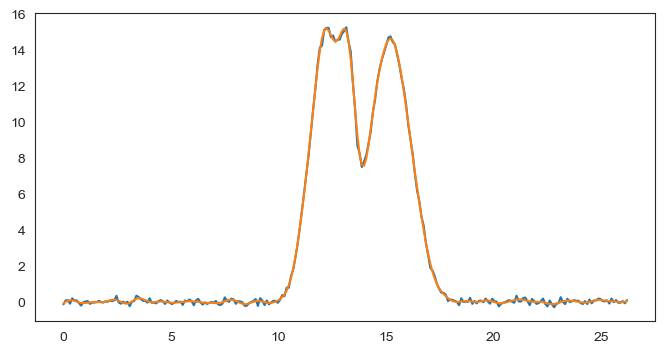

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(time, f1)
ax.plot(time, f1_model)

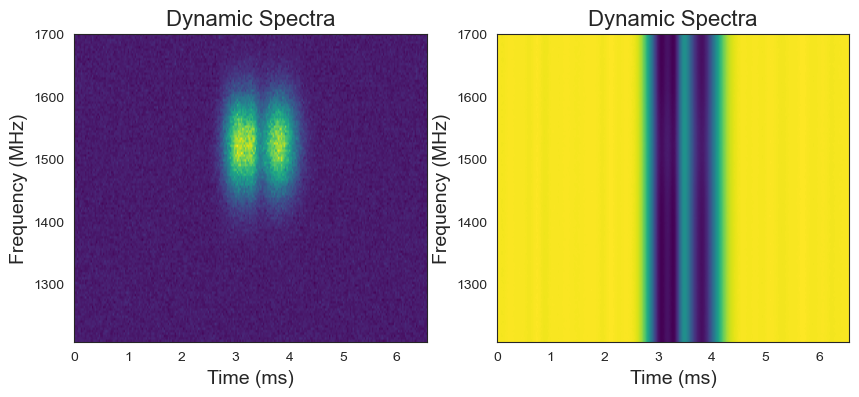

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

plot_dynamic_spectra(b1, ax=ax1)
plot_dynamic_spectra(b1 - f1_model[:,None], ax=ax2)

Let's try another burst:

In [19]:
f2_fit_params, f2_model = fit_gp(time, f2)

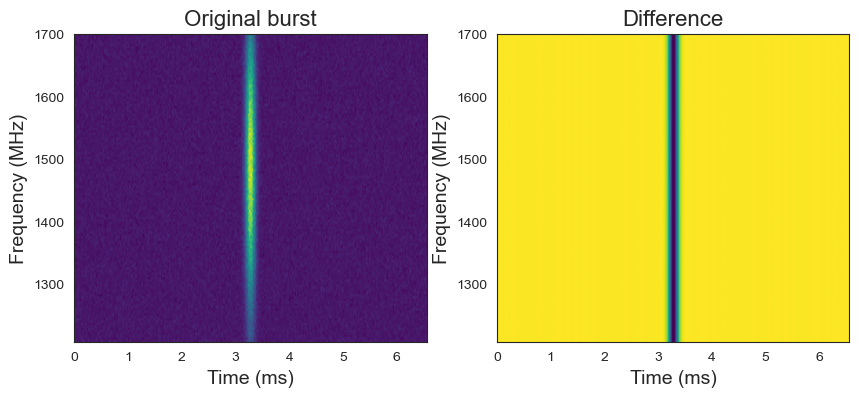

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

plot_dynamic_spectra(b2, ax=ax1, title="Original burst")
plot_dynamic_spectra(b2 - f2_model[:,None], ax=ax2, title="Difference")

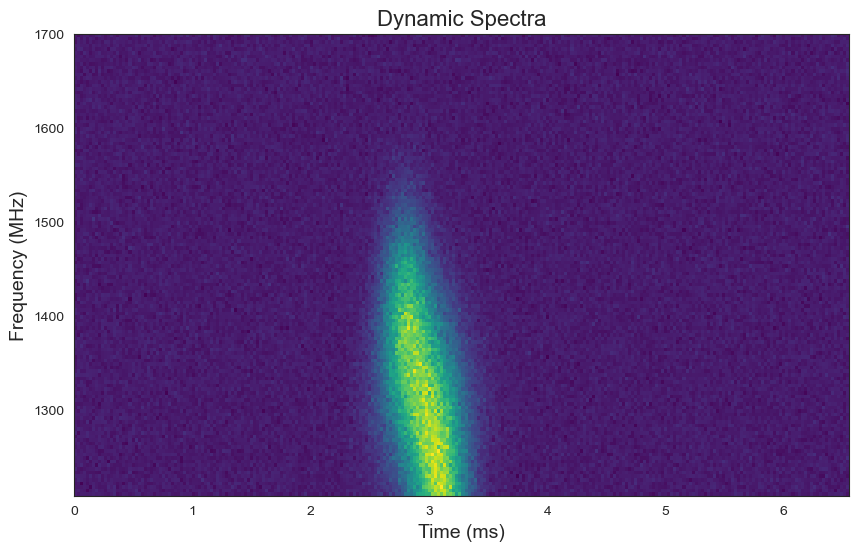

In [21]:
b3 = bursts_rebin["drifting"][0]
f3 = np.sum(b3, axis=1)
plot_dynamic_spectra(b3)

In [22]:
f3_fit_params, f3_model = fit_gp(time, f3)

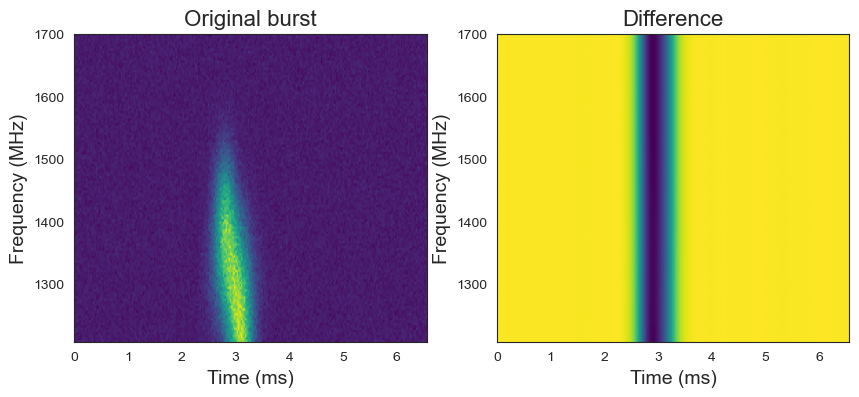

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

plot_dynamic_spectra(b3, ax=ax1, title="Original burst")
plot_dynamic_spectra(b3 - f3_model[:,None], ax=ax2, title="Difference")

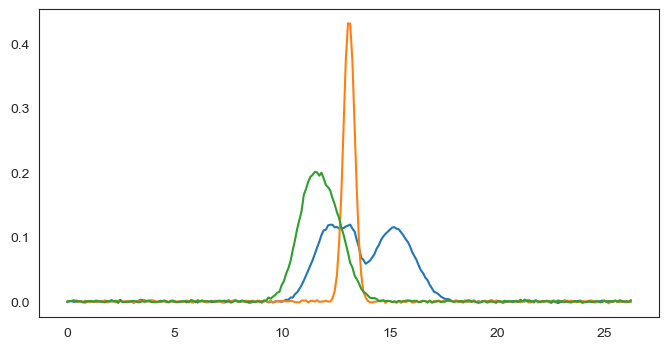

In [24]:
f1 = np.mean(b1, axis=1)
f2 = np.mean(b2, axis=1)
f3 = np.mean(b3, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(time, f1)
ax.plot(time, f2)
ax.plot(time, f3)



In [25]:
f1_fit_params, f1_model = fit_gp(time, f1)
f2_fit_params, f2_model = fit_gp(time, f2)
f3_fit_params, f3_model = fit_gp(time, f3)


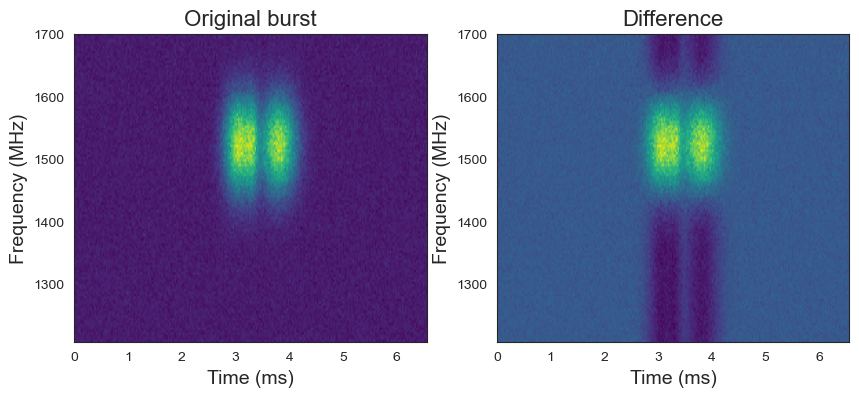

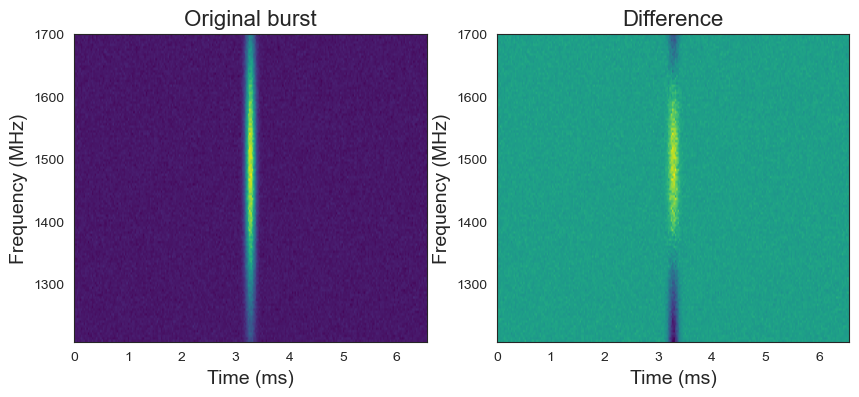

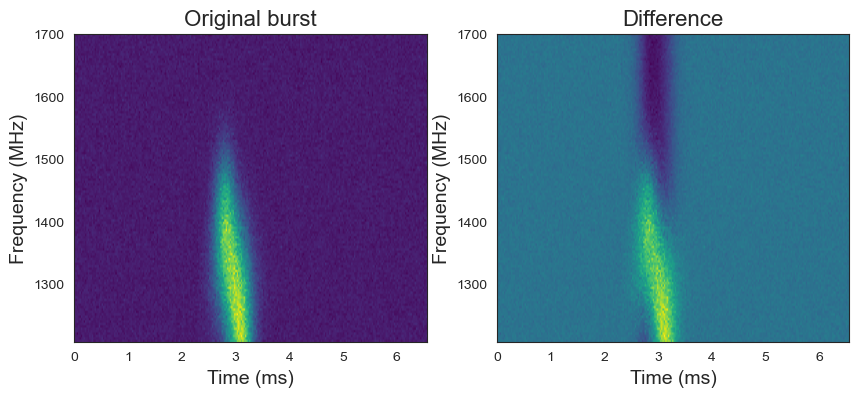

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

plot_dynamic_spectra(b1, ax=ax1, title="Original burst")
plot_dynamic_spectra(b1 - f1_model[:,None], ax=ax2, title="Difference")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

plot_dynamic_spectra(b2, ax=ax1, title="Original burst")
plot_dynamic_spectra(b2 - f2_model[:,None], ax=ax2, title="Difference")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

plot_dynamic_spectra(b3, ax=ax1, title="Original burst")
plot_dynamic_spectra(b3 - f3_model[:,None], ax=ax2, title="Difference")

Let's use a fast version of a Matern kernel:

In [27]:
def build_gp(params, x):
    kernel = jnp.exp(params["log_amp"])*kernels.ExpSquared(jnp.exp(params["log_scale"]))
    return GaussianProcess(kernel, x, diag=jnp.exp(params["log_diag"]))


In [28]:
%timeit f1_fit_params, f1_model = fit_gp(time, f1.astype(np.float64))

420 ms ± 28.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
f1_fit_params, f1_model = fit_gp(time, f1.astype(np.float64))

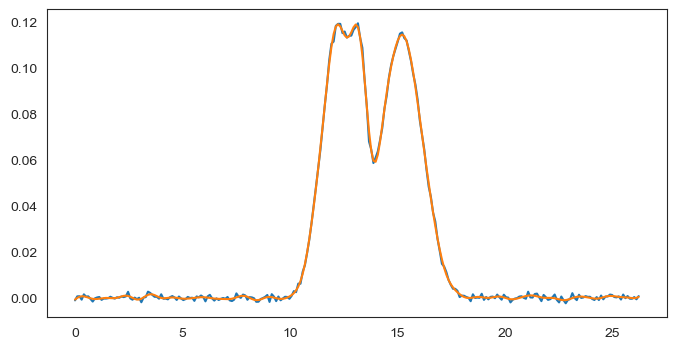

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(time, f1)
ax.plot(time, f1_model)

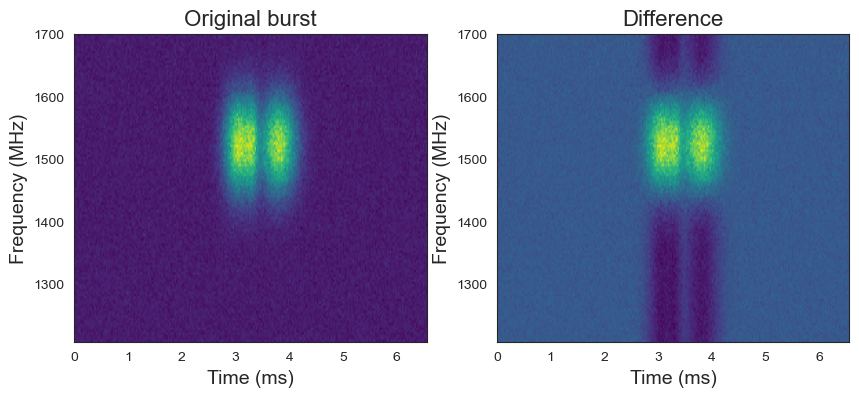

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

plot_dynamic_spectra(b1, ax=ax1, title="Original burst")
plot_dynamic_spectra(b1 - f1_model[:,None], ax=ax2, title="Difference")


Let's run through all of the bursts:

### Loading GP Results from File

First for the non-binned data:

In [ ]:
burst_params = {}
burst_mfit = {}
burst_diff = {}


for i, c in enumerate(cats):
    # construct string for the correct directory
    cat_string = datadir + file_basestring + c + "/residuals/"

    param_string = cat_string + c + "_gp_matern32_params.dat"
    fit_string = cat_string + c + "_gp_matern32_fitmodel.dat"

    burst_params[c] = np.loadtxt(param_string)
    burst_mfit[c] = np.loadtxt(fit_string)
    
    # find all burst files
    resfiles = glob.glob(cat_string  + "*.npy")

    resdata_all = []
    # load all bursts from this type of bursts:
    bdata_all = []
    for ff in resfiles:
        rdata = np.load(ff)
        resdata_all.append(rdata)
        
    resdata_all = np.array(resdata_all)

    burst_diff[c] = resdata_all

Now for the **binned** data:

In [41]:
burst_params = {}
burst_mfit = {}
burst_diff = {}

for i, c in enumerate(cats):
    # construct string for the correct directory
    cat_string = datadir + file_basestring + c + "/residuals_binned/"

    param_string = cat_string + c + "_gp_matern32_params.dat"
    fit_string = cat_string + c + "_gp_matern32_fitmodel.dat"

    burst_params[c] = np.loadtxt(param_string)
    burst_mfit[c] = np.loadtxt(fit_string)
    
    # find all burst files
    resfiles = glob.glob(cat_string  + "*.npy")

    resdata_all = []
    # load all bursts from this type of bursts:
    bdata_all = []
    for ff in resfiles:
        rdata = np.load(ff)
        resdata_all.append(rdata)
        
    resdata_all = np.array(resdata_all)

    burst_diff[c] = resdata_all

In [43]:
burst_diff[c].shape

(1000, 1024, 512)

### Calculating difference images from just the GP fits:

In [45]:
burst_diff = {}

for c in cats:
    bdiff = []
    bdata = bursts_rebin[c]
    mfit = burst_mfit[c]
    for bd, m in zip(bdata, mfit):
        bdiff.append(bd - m[:,None])

    bdiff = np.array(bdiff)
    burst_diff[c] = bdiff


### Running GP Results from scratch

In [47]:
burst_fit = {}

nbursts = 1000 # --> commenting out so this doesn't clobber everything if I accidentally run it

for c in cats:
    params, mfit, subtracted_bursts = [], [], []
    print(f"I am on category {c}")

    for i in range(nbursts):

        if i % 100 == 0:
            print(f"I am on burst {i}")

        b = bursts_rebin[c][i]
        flux = np.mean(b, axis=1)
        fp, fm = fit_gp(time, flux.astype(np.float64))
        params.append(fp)
        mfit.append(fm)
        subtracted_bursts.append(b - flux[:,None])

    burst_fit[c] = [np.array(params), np.array(mfit), np.array(subtracted_bursts)]

I am on category complex
I am on burst 0
I am on burst 100
I am on burst 200
I am on burst 300
I am on burst 400
I am on burst 500
I am on burst 600
I am on burst 700
I am on burst 800
I am on burst 900
I am on category drifting
I am on burst 0
I am on burst 100
I am on burst 200
I am on burst 300
I am on burst 400
I am on burst 500
I am on burst 600
I am on burst 700
I am on burst 800
I am on burst 900
I am on category simple_broad
I am on burst 0
I am on burst 100
I am on burst 200
I am on burst 300
I am on burst 400
I am on burst 500
I am on burst 600
I am on burst 700
I am on burst 800
I am on burst 900
I am on category simple_narrow
I am on burst 0
I am on burst 100
I am on burst 200
I am on burst 300
I am on burst 400
I am on burst 500
I am on burst 600
I am on burst 700
I am on burst 800
I am on burst 900
I am on category simulated_scattered
I am on burst 0
I am on burst 100
I am on burst 200
I am on burst 300
I am on burst 400
I am on burst 500
I am on burst 600
I am on burst 7

Let's look at some stuff:

In [48]:
burst_params = {}
burst_mfit = {}
burst_diff = {}
for c in cats:
    bp = burst_fit[c][0]
    burst_params[c] = np.array([list(bp[i].values()) for i in range(len(bp))])
    burst_mfit[c] = burst_fit[c][1]
    burst_diff[c] = burst_fit[c][2]
    

Saving the results to file:

In [56]:
# empty dict for all burst data
bursts = {}

res_folder = "/residuals_binned/"

# start with first index
for i, c in enumerate(cats):
    # construct string for the correct directory
    cat_string = datadir + file_basestring + c  + "/"
    res_string = cat_string + res_folder
    # find all burst files
    burstfiles = glob.glob(cat_string  + "*.npy")
    print(burstfiles)
    np.savetxt(res_string + c + "_gp_matern32_params.dat", burst_params[c])
    np.savetxt(res_string + c + "_gp_matern32_fitmodel.dat", burst_mfit[c])
    # save all bursts from this type of bursts:

    for i, bf in enumerate(burstfiles):
        savfile = "/".join(bf.split(".")[0].split("/")[:-1]) + res_folder + bf.split(".")[0].split("/")[-1] + "_res.npy"
        np.save(savfile, burst_diff[c][i])


['/Users/daniela/work/data/frbs/sims/1000_Constant_SNR_complex/CP_893.npy', '/Users/daniela/work/data/frbs/sims/1000_Constant_SNR_complex/CP_887.npy', '/Users/daniela/work/data/frbs/sims/1000_Constant_SNR_complex/CP_139.npy', '/Users/daniela/work/data/frbs/sims/1000_Constant_SNR_complex/CP_111.npy', '/Users/daniela/work/data/frbs/sims/1000_Constant_SNR_complex/CP_677.npy', '/Users/daniela/work/data/frbs/sims/1000_Constant_SNR_complex/CP_663.npy', '/Users/daniela/work/data/frbs/sims/1000_Constant_SNR_complex/CP_105.npy', '/Users/daniela/work/data/frbs/sims/1000_Constant_SNR_complex/CP_688.npy', '/Users/daniela/work/data/frbs/sims/1000_Constant_SNR_complex/CP_850.npy', '/Users/daniela/work/data/frbs/sims/1000_Constant_SNR_complex/CP_844.npy', '/Users/daniela/work/data/frbs/sims/1000_Constant_SNR_complex/CP_878.npy', '/Users/daniela/work/data/frbs/sims/1000_Constant_SNR_complex/CP_449.npy', '/Users/daniela/work/data/frbs/sims/1000_Constant_SNR_complex/CP_475.npy', '/Users/daniela/work/dat

### Continue here after loading in the data

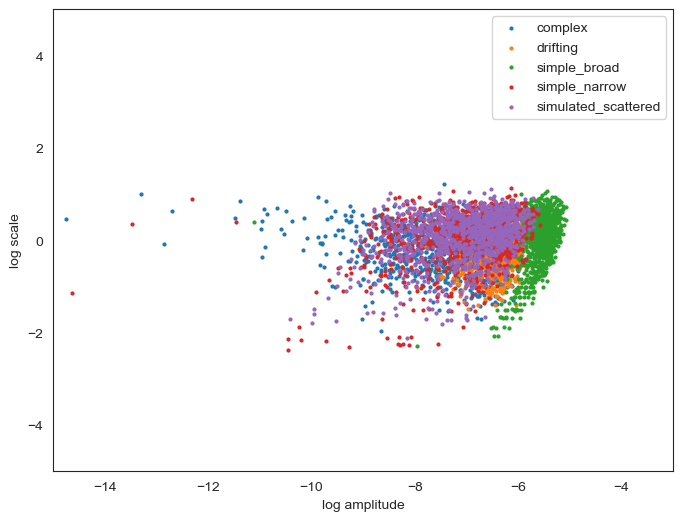

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

for i,c in enumerate(cats):
    ax.scatter(burst_params[c][:,0], burst_params[c][:,2], s=4, 
               color=sns.color_palette()[i], label=c)
    ax.set_xlabel("log amplitude")
    ax.set_ylabel("log scale")

ax.set_xlim(-15, -3)
ax.set_ylim(-5, 5)
ax.legend()

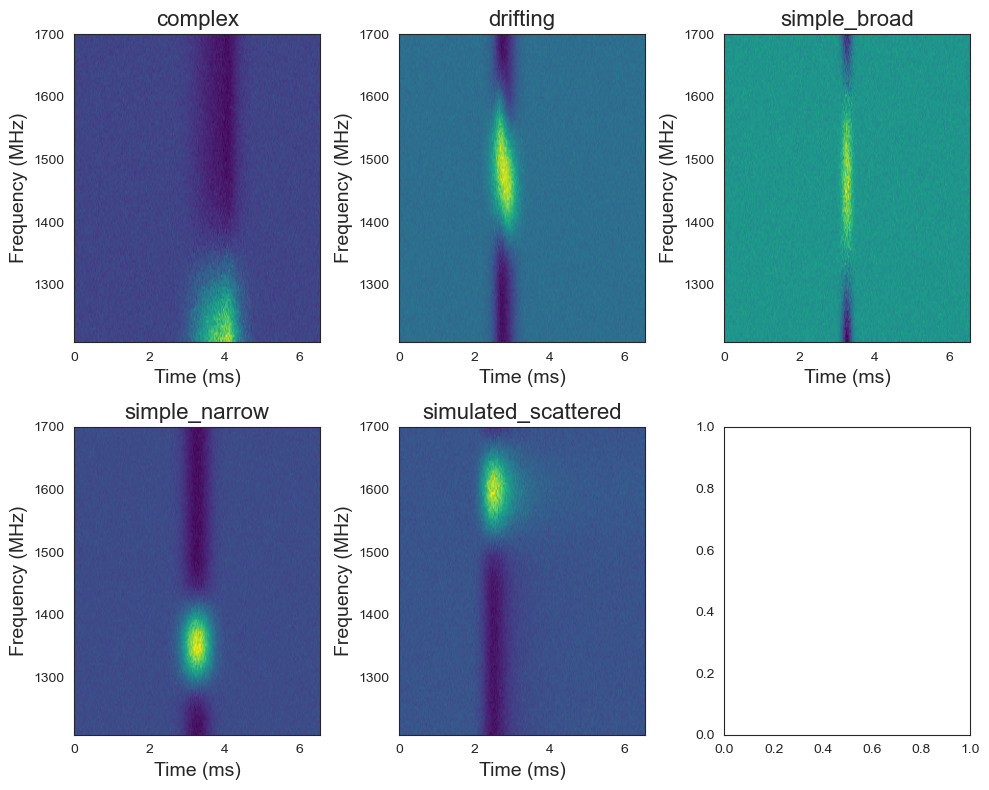

In [58]:
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

axes = np.hstack(axes)

for i, c in enumerate(cats):
    idx = np.random.randint(0, 1000)
    sb = burst_diff[c][idx]

    plot_dynamic_spectra(sb, ax=axes[i], title=c)

plt.tight_layout()

## PCA

Let's do PCA on the residuals?

In [59]:
burst_shape = burst_diff[c][0].shape

In [60]:
all_residuals = np.array([burst_diff[c] for c in cats])
all_residuals = all_residuals.reshape((5000, *burst_shape))

#all_residuals = all_residuals.reshape((5000, 1024, 512))
labels = np.hstack([[c]*1000 for c in cats])

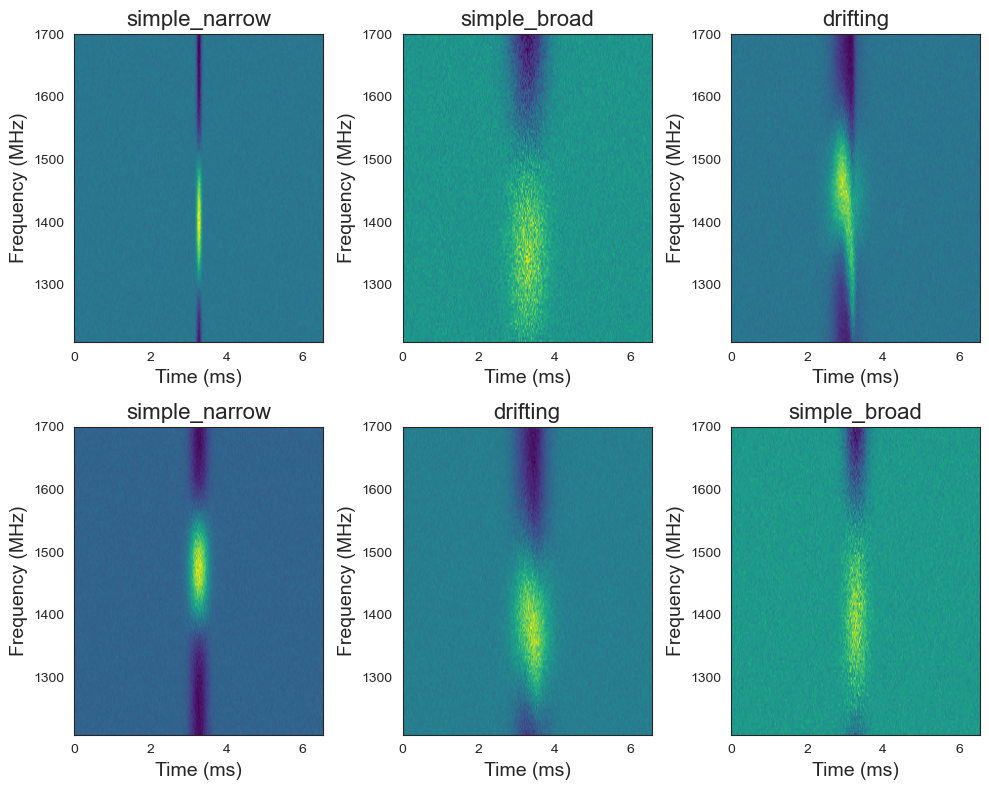

In [61]:
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

axes = np.hstack(axes)

for i in range(6):
    idx = np.random.randint(0, 5000)
    sb = all_residuals[idx,:,:]
    l = labels[idx]

    plot_dynamic_spectra(sb, ax=axes[i], title=l)

plt.tight_layout()

Now we can do the test_train_split:

In [62]:
train_res, test_res, train_labels, test_labels = train_test_split(all_residuals, labels, test_size=0.2, shuffle=True, random_state=100)
train_res_flat = train_res.reshape(4000, burst_shape[0]*burst_shape[1])
test_res_flat = test_res.reshape(1000, burst_shape[0]*burst_shape[1])

Let's also make a standard-scaled version:

In [63]:
train_res_flat.shape

(4000, 32768)

In [64]:
scaler = StandardScaler()
train_res_scaled = scaler.fit_transform(train_res_flat[:4000])
#test_res_scaled = scaler.transform(test_res_flat)

In [65]:
test_res_scaled = scaler.transform(test_res_flat)

Now we can run PCA:

In [66]:
ncomp = 20
pca = PCA(n_components=ncomp)
res_pca = pca.fit_transform(train_res_flat)
#pca_all[ncomp] = pca
#pca_comp_all[ncomp] = res_pca

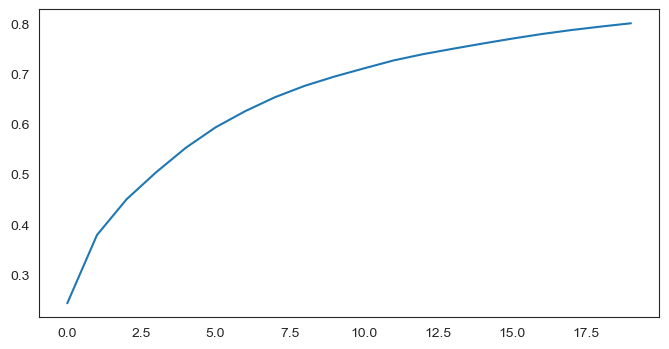

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(np.arange(20), np.cumsum(pca.explained_variance_ratio_))

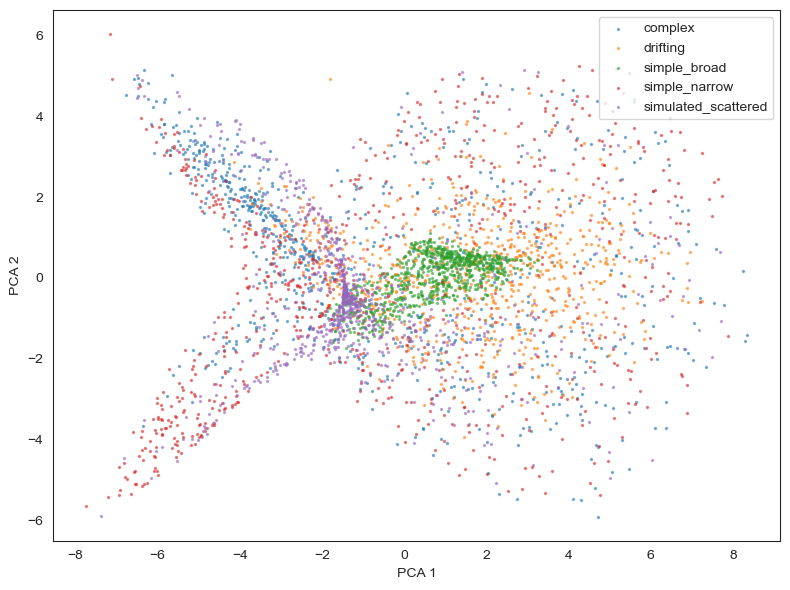

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

for i,c in enumerate(cats):
    mask = (train_labels == c)
    ax.scatter(res_pca[mask,1], res_pca[mask,3], s=2, alpha=0.5, color=sns.color_palette()[i], label=c)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.legend()
plt.tight_layout()

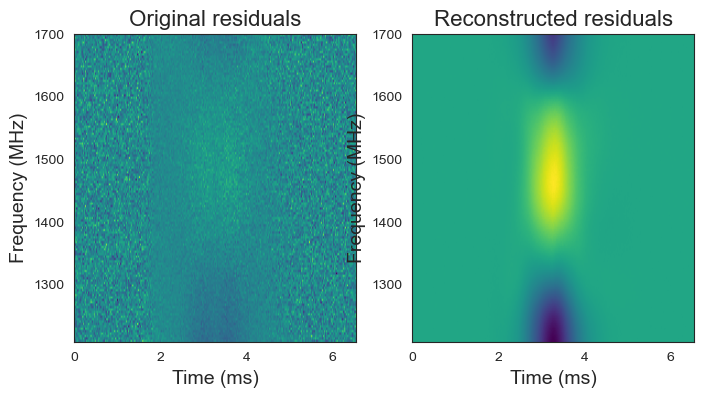

In [69]:
idx = np.random.randint(0, 4000)
b = train_res_scaled[idx].reshape(train_res[idx].shape)
b_trans = pca.inverse_transform(res_pca[idx]).reshape(b.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

plot_dynamic_spectra(b, ax=ax1, title="Original residuals")
plot_dynamic_spectra(b_trans, ax=ax2, title="Reconstructed residuals")

Compute the mean-squared error:

In [70]:
mse_all = {}
for c in cats:
    mask = (train_labels == c)
    pca_comp_tmp = res_pca[mask,:]
    train_res_tmp = train_res_flat[mask, :]
    train_res_trans = pca.inverse_transform(pca_comp_tmp)
    
    mse = mean_squared_error(train_res_tmp, train_res_trans, multioutput="raw_values")
    mse_all[c] = mse

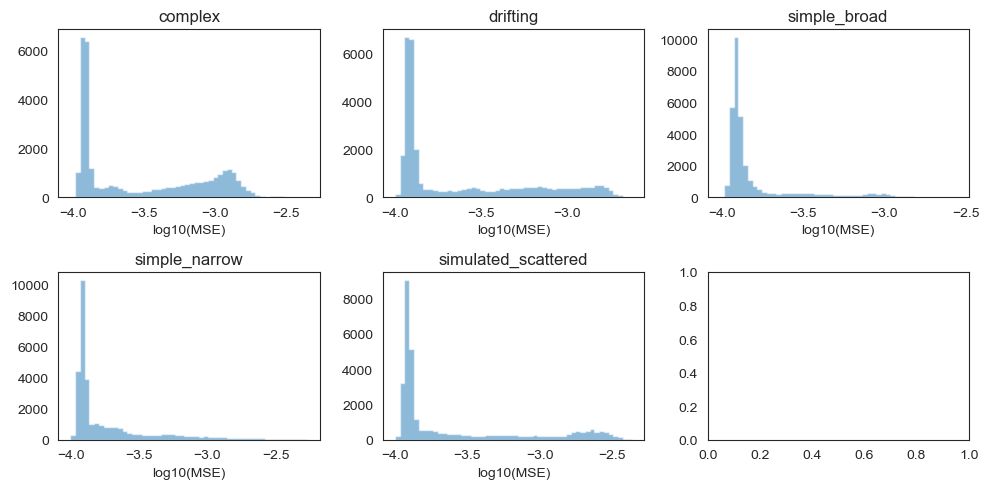

In [71]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))

axes = np.hstack(axes)

for i,c in enumerate(cats):
    axes[i].hist(np.log10(mse_all[c]), bins=50, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(c)
    axes[i].set_xlabel("log10(MSE)")

fig.tight_layout()

### UMAP

What about UMAP?

In [72]:
reducer = umap.UMAP(n_neighbors=15, n_components=5)
embedding = reducer.fit_transform(train_res_scaled)

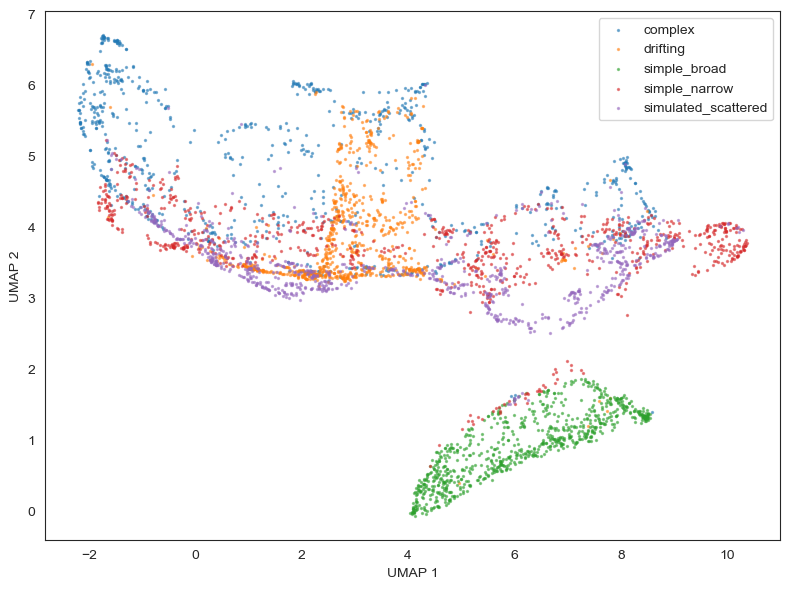

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

for i,c in enumerate(cats):
    mask = (train_labels == c)
    ax.scatter(embedding[mask,0], embedding[mask,2], s=2, alpha=0.5, color=sns.color_palette()[i], label=c)

ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.legend()
plt.tight_layout()

Clustering in the 5D space?

In [76]:
from sklearn.cluster import KMeans

In [78]:
embedding.shape

(4000, 5)

In [ ]:
km = KMeans(n_clusters=5).fit(embedding)

/opt/miniconda3/envs/frb_iob/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
embedding.shape

In [153]:
from sklearn.cluster import DBSCAN

In [164]:
db = DBSCAN().fit(embedding)

In [165]:
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)



Estimated number of clusters: 2
Estimated number of noise points: 7


(array([   7.,    0., 3147.,    0.,  846.]),
 array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ]),
 <BarContainer object of 5 artists>)

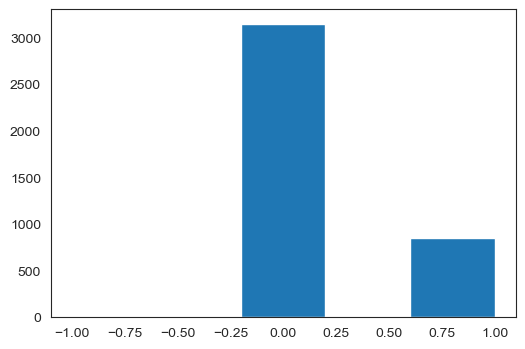

In [162]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(dbscan.labels_, bins=5)

In [167]:
from sklearn import metrics

In [169]:
print(f"Homogeneity: {metrics.homogeneity_score(train_labels, labels):.3f}")
print(f"Completeness: {metrics.completeness_score(train_labels, labels):.3f}")
print(f"V-measure: {metrics.v_measure_score(train_labels, labels):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(train_labels, labels):.3f}")
print(
    "Adjusted Mutual Information:"
    f" {metrics.adjusted_mutual_info_score(train_labels, labels):.3f}"
)
print(f"Silhouette Coefficient: {metrics.silhouette_score(embedding, labels):.3f}")

Homogeneity: 0.280
Completeness: 0.851
V-measure: 0.421
Adjusted Rand Index: 0.204
Adjusted Mutual Information: 0.420
Silhouette Coefficient: -0.056


Let's also try DensMap:

In [142]:
dens_mapper = umap.UMAP(densmap=True, dens_lambda=0.6, random_state=42, n_components=5).fit(train_res_scaled)
densmap_embedding = dens_mapper.transform(train_res_scaled)

/opt/miniconda3/envs/frb_iob/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


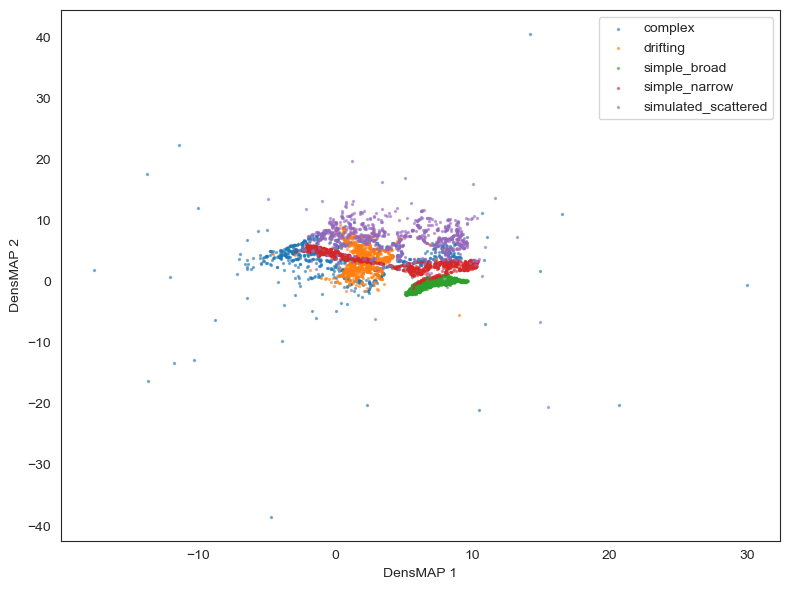

In [144]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

for i,c in enumerate(cats):
    mask = (train_labels == c)
    ax.scatter(densmap_embedding[mask,0], densmap_embedding[mask,1], s=2, alpha=0.5, color=sns.color_palette()[i], label=c)

ax.set_xlabel("DensMAP 1")
ax.set_ylabel("DensMAP 2")
#ax.set_xlim(-20, 20)
#ax.set_ylim(-20, 20)
ax.legend()
plt.tight_layout()